In [1]:
# Step 1: Imports and GPU check
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name() or "No GPU detected — enable it in Runtime > Change runtime type")


TensorFlow version: 2.19.0
GPU: /device:GPU:0


In [2]:
# Step 2: Load the IMDb dataset
num_words = 10000  # Keep top 10,000 most frequent words
maxlen = 200       # Max sequence length per review

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
print(f"Training samples: {len(x_train)}, Test samples: {len(x_test)}")

# Check one sample
print("Example review (word indices):", x_train[0][:20])
print("Label (0=negative, 1=positive):", y_train[0])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 25000, Test samples: 25000
Example review (word indices): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
Label (0=negative, 1=positive): 1


In [3]:
# Step 3: Pad all sequences to same length
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print("After padding:", x_train.shape, x_test.shape)


After padding: (25000, 200) (25000, 200)


In [4]:
# Step 4: Build the RNN (LSTM) model
embedding_dim = 64

model = keras.Sequential([
    layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    layers.SpatialDropout1D(0.2),
    layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary output (positive/negative)
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Step 5: Compile and set up callbacks
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_cb = callbacks.ModelCheckpoint('best_imdb_lstm.keras', save_best_only=True)


In [6]:
# Step 6: Train the model
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[earlystop_cb, checkpoint_cb],
    verbose=2
)


Epoch 1/10
157/157 - 114s - 723ms/step - accuracy: 0.7225 - loss: 0.5367 - val_accuracy: 0.8298 - val_loss: 0.3811
Epoch 2/10
157/157 - 103s - 657ms/step - accuracy: 0.8594 - loss: 0.3388 - val_accuracy: 0.8322 - val_loss: 0.3737
Epoch 3/10
157/157 - 103s - 655ms/step - accuracy: 0.8838 - loss: 0.2917 - val_accuracy: 0.8540 - val_loss: 0.3614
Epoch 4/10
157/157 - 143s - 910ms/step - accuracy: 0.9000 - loss: 0.2583 - val_accuracy: 0.8332 - val_loss: 0.3867
Epoch 5/10
157/157 - 103s - 659ms/step - accuracy: 0.8991 - loss: 0.2553 - val_accuracy: 0.8136 - val_loss: 0.4278
Epoch 6/10
157/157 - 103s - 656ms/step - accuracy: 0.9192 - loss: 0.2143 - val_accuracy: 0.8082 - val_loss: 0.4612


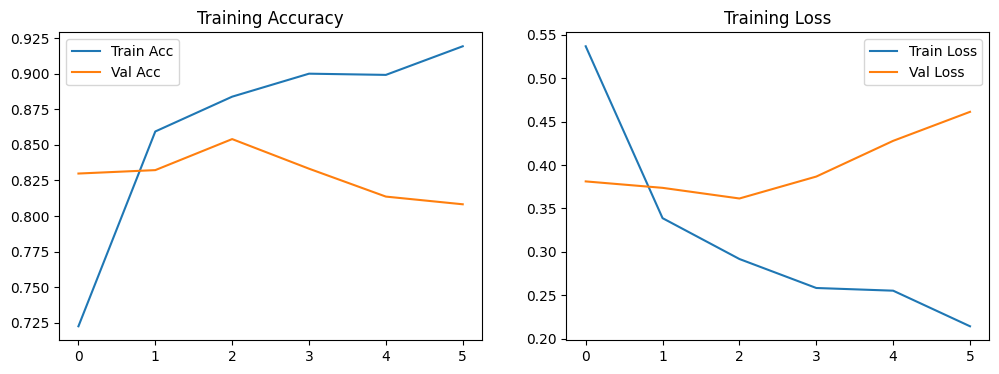

In [7]:
# Step 7: Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss")
plt.show()


In [8]:
# Step 8: Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


782/782 - 86s - 111ms/step - accuracy: 0.8544 - loss: 0.3585
Test Accuracy: 0.8544, Test Loss: 0.3585


782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 118ms/step


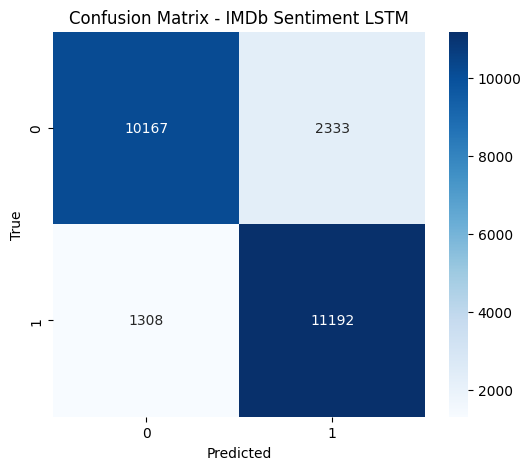

              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85     12500
    Positive       0.83      0.90      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



In [9]:
# Step 9: Confusion matrix & classification report
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - IMDb Sentiment LSTM")
plt.show()

print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


In [10]:
# Step 10: Try custom reviews
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

def decode_review(encoded):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded])

# Display one decoded review
print("Sample decoded review:\n", decode_review(x_train[0]))

# Predict on first 5 test samples
sample_preds = y_pred[:5].flatten()
for i in range(5):
    print(f"Review {i+1}: {'Positive' if sample_preds[i]==1 else 'Negative'} | Actual: {'Positive' if y_test[i]==1 else 'Negative'}")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Sample decoded review:
 and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it w

In [11]:
# Step 11: Save final model
model.save("final_imdb_lstm_model.keras")
print("✅ Model saved as final_imdb_lstm_model.keras")


✅ Model saved as final_imdb_lstm_model.keras
